# Train experiments

Nota: se instala por terminal databricks y se configura para usar MLflow de databricks community.

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import mlflow

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
def load_and_preprocess_file(file_path, scaler=None):
    df = pd.read_parquet(file_path)
    data = df.values
    if scaler:
        data = scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    return data

def data_generator(file_paths, labels, batch_size, scaler=None):
    while True:
        for start in range(0, len(file_paths), batch_size):
            end = min(start + batch_size, len(file_paths))
            batch_files = file_paths[start:end]
            batch_labels = labels[start:end]

            batch_data = [load_and_preprocess_file(f, scaler) for f in batch_files]
            batch_data = np.array(batch_data)

            yield batch_data, np.array(batch_labels)

def get_label_for_file(file):
    label = file.split("_")[2]
    label_dict = {
        "prepreictal": 1,
        "preictal": 1,
        "ictal": 0,
        "interictal": 0,
    }

    return label_dict[label]

FOLDER = "windows_per_parquet"

print("Reading files")
file_paths = [os.path.join(FOLDER, file) for file in os.listdir(FOLDER) if file.endswith('.parquet')]
labels = [get_label_for_file(file) for file in os.listdir(FOLDER) if file.endswith('.parquet')]

file_paths_train, file_paths_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

scaler = StandardScaler()

print("Fit scaler")
sample_data = []
for file_path in file_paths_train[:200]: # fit with only 200 files
    sample_data.append(load_and_preprocess_file(file_path))
sample_data = np.array(sample_data).reshape(-1, sample_data[0].shape[-1])
scaler.fit(sample_data)

batch_size = 32

train_gen = data_generator(file_paths_train, y_train, batch_size, scaler)
test_gen = data_generator(file_paths_test, y_test, batch_size, scaler)

steps_per_epoch = len(file_paths_train) // batch_size
validation_steps = len(file_paths_test) // batch_size

Reading files
Fit scaler


In [59]:
# n_classes_train = len(np.unique(y_train))
n_classes_train = 1 # para binaria

In [63]:
from tensorflow.keras.regularizers import l2


def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(15360, 22)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),  # Regularización L2
        tf.keras.layers.Dense(n_classes_train, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 15358, 64)         4288      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7679, 64)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 491456)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               62906496  
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 62,910,913
Trainable params: 62,910,913
Non-trainable params: 0
__________________________________________

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    # input1   = Input(shape = (Chans, Samples, 1))
    input1   = Input(shape = (Samples, Chans, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Samples, Chans, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 2))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 4))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    # softmax      = Activation('softmax', name = 'softmax')(dense)

    # return Model(inputs=input1, outputs=softmax)
    sigmoid      = Activation('sigmoid', name = 'sigmoid')(dense)

    return Model(inputs=input1, outputs=sigmoid)


model = EEGNet(nb_classes=1, Chans=22, Samples=15360, dropoutRate=0.1, kernLength=128)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15360, 22, 1)]    0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15360, 22, 8)      1024      
                                                                 
 batch_normalization_6 (Batc  (None, 15360, 22, 8)     32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 15339, 22, 16)    352       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 15339, 22, 16)    64        
 hNormalization)                                                 
                                                           

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=test_gen,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping_callback]
)


test_loss, test_acc = model.evaluate(test_gen, steps=validation_steps)
print(f'Test accuracy: {test_acc}')


Epoch 1/50


2024-07-27 18:51:16.008832: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - 81s 814ms/step - loss: 0.8515 - accuracy: 0.5410 - val_loss: 0.7057 - val_accuracy: 0.3190
Epoch 2/50
26/97 [=======>......................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5636

In [34]:
mlflow.keras.log_model(model, "model")

2024/07/27 18:06:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpo_have0r/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpo_have0r/model/data/model/assets
2024/07/27 18:06:39 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


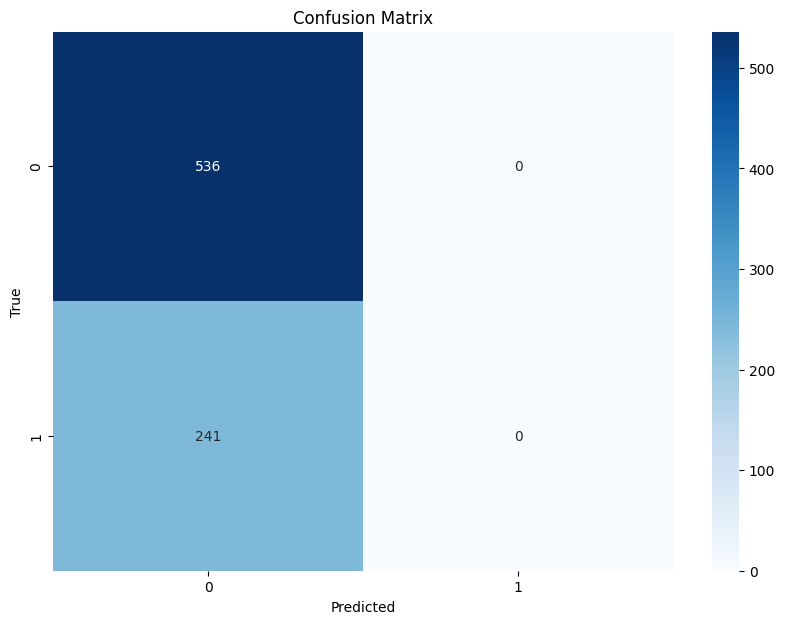

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []
filenames_test = []

for i in range(validation_steps+1):
    filenames_test.extend(file_paths_test[batch_size*i:batch_size*(i+1)])
    X_batch, y_batch = next(test_gen)
    y_true.extend(y_batch)
    y_pred_batch = np.argmax(model.predict(X_batch), axis=-1)
    y_pred.extend(y_pred_batch)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("cm_1.jpg")
plt.show()


In [36]:
model.save('modelo_1.h5')

## Métricas

In [37]:
import tensorflow as tf



model = tf.keras.models.load_model('modelo_1.h5')

# Mostrar un resumen del modelo para confirmar que se cargó correctamente
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15360, 22, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 15360, 22, 8)      1024      
                                                                 
 batch_normalization (BatchN  (None, 15360, 22, 8)     32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 15339, 22, 16)    352       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 15339, 22, 16)    64        
 hNormalization)                                                 
                                                             

In [38]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calcular y mostrar el classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calcular otras métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       536
           1       0.00      0.00      0.00       241

    accuracy                           0.69       777
   macro avg       0.34      0.50      0.41       777
weighted avg       0.48      0.69      0.56       777

Accuracy: 0.6898
Precision: 0.4759
Recall: 0.6898
F1 Score: 0.5632


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [39]:
import pandas as pd

results_test = pd.DataFrame({"filename": filenames_test})
results_test["y"] = y_true
results_test["y_pred"] = y_pred

results_test["patient"] = results_test["filename"].apply(lambda x: x.split("_")[2].split("/")[-1])

results_test["preictal_true"] = results_test["y"].apply(lambda x: x == 1)
results_test["preictal_pred"] = results_test["y_pred"].apply(lambda x: x == 1)

# there are some chb17a, chb17b, etc. we rename those to chb17
chb_indexes = results_test.query("patient.str.startswith('chb17')").index
results_test.loc[chb_indexes, "patient"] = "chb17"

results_test

,filename,y,y_pred,patient,preictal_true,preictal_pred
0,windows_per_parquet/chb12_33_prepreictal_1.par...,1,0,chb12,True,False
1,windows_per_parquet/chb01_07_interictal_3.parquet,0,0,chb01,False,False
2,windows_per_parquet/chb01_19_interictal_3.parquet,0,0,chb01,False,False
3,windows_per_parquet/chb10_15_interictal_1.parquet,0,0,chb10,False,False
4,windows_per_parquet/chb21_09_interictal_0.parquet,0,0,chb21,False,False
...,...,...,...,...,...,...
772,windows_per_parquet/chb04_36_interictal_0.parquet,0,0,chb04,False,False
773,windows_per_parquet/chb22_29_interictal_2.parquet,0,0,chb22,False,False
774,windows_per_parquet/chb14_18_preictal_1.parquet,1,0,chb14,True,False
775,windows_per_parquet/chb18_20_interictal_2.parquet,0,0,chb18,False,False


In [21]:
results_test.preictal_true.value_counts()

preictal_true
False    536
True     241
Name: count, dtype: int64

In [22]:
results_test.patient.value_counts().describe()

count    24.000000
mean     32.375000
std      11.705861
min      14.000000
25%      24.250000
50%      33.000000
75%      40.000000
max      63.000000
Name: count, dtype: float64

<Axes: xlabel='patient'>

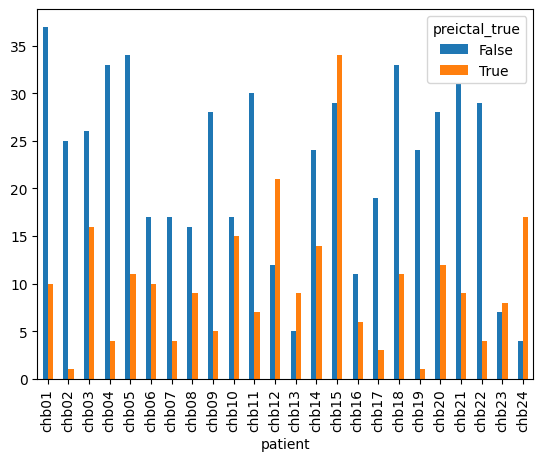

In [23]:
results_test[["patient", "preictal_true"]].value_counts().unstack().plot(kind="bar")

In [40]:
results_test.to_csv("resultados_test_1.csv", index=False)

In [41]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


class_report = classification_report(results_test["preictal_true"], results_test["preictal_pred"])
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(results_test["preictal_true"], results_test["preictal_pred"])
precision = precision_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')
recall = recall_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')
f1 = f1_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

       False       0.69      1.00      0.82       536
        True       0.00      0.00      0.00       241

    accuracy                           0.69       777
   macro avg       0.34      0.50      0.41       777
weighted avg       0.48      0.69      0.56       777

Accuracy: 0.6898
Precision: 0.4759
Recall: 0.6898
F1 Score: 0.5632


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [42]:
recall_score(results_test["preictal_true"], results_test["preictal_pred"])

0.0

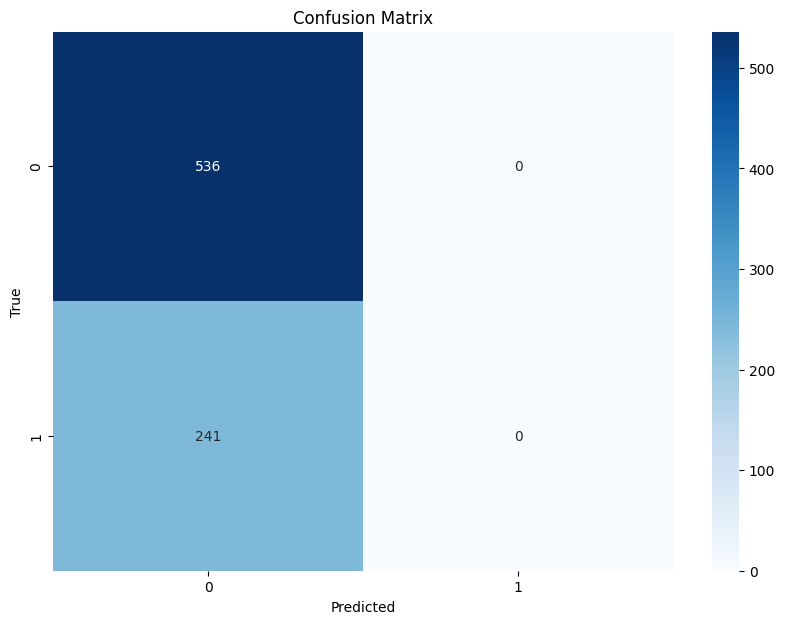

In [50]:
conf_matrix = confusion_matrix(results_test["preictal_true"], results_test["preictal_pred"])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("cm_bin.jpg")
plt.show()

In [65]:
tn, fp, fn, tp = confusion_matrix(results_test["preictal_true"], results_test["preictal_pred"]).ravel()

# Calcular las métricas
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"False Positive Rate: {fpr}")
print(f"False Negative Rate: {fnr}")

Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.6898326898326899
Precision: nan
F1 Score: nan
False Positive Rate: 0.0
False Negative Rate: 1.0


/tmp/ipykernel_526/2919425270.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


# Log MLflow

In [48]:
mlflow.end_run()

In [51]:
import mlflow
import mlflow.keras

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/mnsosa@mi.unc.edu.ar/seizure-prediction")

with mlflow.start_run(run_name=RUN_NAME) as run:
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("class_weights", class_weights)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("n_classes_train", n_classes_train)

    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    
    mlflow.log_metric("sensitivity", sensitivity)
    mlflow.log_metric("specificity", specificity)
    mlflow.log_metric.log_metric("precision", precision)
    mlflow.log_metric("F1 Score", f1_score)
    mlflow.log_metric("False Positive Rate", fpr)
    mlflow.log_metric("False Negative Rate", fnr)


    mlflow.log_artifact("cm_1.jpg")
    mlflow.log_artifact("cm_bin.jpg")


    mlflow.keras.log_model(model, "model")


2024/07/27 18:17:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp1_sp4p2k/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp1_sp4p2k/model/data/model/assets
2024/07/27 18:17:50 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]